In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
df = pd.read_csv('train.csv', encoding='ISO-8859-1')

## is_converted 칼럼 정리

In [3]:
#1. is_converted가 NA인 데이터 drop
df = df.dropna(subset=['is_converted'])
erased_rows = 59300-len(df)
print('지워진 행: '+str(erased_rows))

지워진 행: 1


In [4]:
print('is_converted unique values:')
df.is_converted.unique()

is_converted unique values:


array([ True, False])

In [5]:
# is_converted 의 값들 정리
# 모두 TRUE or FALSE로 통일, 이외값을 가진 행은 제거
df['is_converted'] = df['is_converted'].astype(str).str.upper()
df = df[df['is_converted'].isin(['TRUE', 'FALSE'])]
print('지워진 행: '+ str(59300-erased_rows-len(df)))

지워진 행: 0


## 중복 행 처리

In [6]:
df.drop_duplicates(keep='first', inplace=True)
len(df)

55780

## NA율 50% 이상 90% 이하 칼럼들 처리

In [7]:
#칼럼별 NA율이 90% 이상인 칼럼 제외
# drop columns with more than 90% missing values
# dropped_columns = []
# for col in df.columns:
#     if df[col].isnull().sum()/len(df)*100 > 90:
#         df.drop(col, axis=1, inplace=True)
        
# print('number of columns left: '+str(len(df.columns)))

# 칼럼은 train에서 지우면 test에서도 지워야 하므로, 둘 다 지우지 않음

In [8]:
dropped_columns = []
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 90:
        print(col)

id_strategic_ver
it_strategic_ver
idit_strategic_ver
business_subarea


In [13]:
df.id_strategic_ver.fillna(0, inplace=True)
df.it_strategic_ver.fillna(0, inplace=True)
df.idit_strategic_ver.fillna(0, inplace=True)

print(df.id_strategic_ver.unique())
print(df.it_strategic_ver.unique())
print(df.idit_strategic_ver.unique())


[0. 1.]
[0. 1.]
[0. 1.]


In [14]:
df.business_subarea.fillna('Unknown', inplace=True)
print(df.business_subarea.unique())

['Engineering' 'Advertising' 'Construction' 'IT/Software' 'unknown'
 'Manufacturing' 'Energy' 'Developer/Property' 'Entertainment'
 'Agriculture' 'Pharmaceutical' 'Others' 'Banking' 'Consulting'
 'Healthcare' 'Finance' 'Broadcasting & Media' 'Distribution Center'
 'Law Firm' 'Logistics' 'Telecommunication' 'Aerospace' 'Network/Cabling'
 'Insurance' 'Institute & Academy' 'Hotel' 'K12 Kindergarten & Schools'
 'Hospital' 'Mixed-use (Multi Complex)'
 'Telecom Base Station / Data, Call' 'Botanical Garden / Green House'
 'Higher Education (College & University)' 'Clinic' 'General Hospital'
 'Fitness' 'LTC(Long-Term Care)' 'Villa / Single-Family Home' 'Apartment'
 'Townhouse' 'Officetel' 'General Government Office' 'Military'
 'Police / Fire station' 'Welfare Facilities' 'Other Stores'
 'Luxury(Watch/Jewelry Shop)' 'Electronics & Telco' 'Sports Entertainment'
 'CVS (Convenience Store)' 'Car Dealership' 'Fashion'
 'QSR(Quick Service Restaurant)' 'Hyper Market & Grocery' 'Shopping Mall'
 'Cosme

In [15]:
#칼럼별 NA율이 50% 이상인 칼럼 나열
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 50:
        print(col, df[col].isnull().sum()/len(df)*100)
        #df.drop(col, axis=1, inplace=True)

com_reg_ver_win_rate 74.69702402294729
customer_type 74.14485478666188
historical_existing_cnt 77.82359268555038
product_subcategory 83.85442811043384
product_modelname 83.80960917891717
expected_timeline 50.72068841878809
ver_win_rate_x 68.11222660451774
ver_win_ratio_per_bu 73.31660093223378
business_area 68.11222660451774


### com_reg_ver_win_rate

In [215]:
# Replace NA values in 'com_reg_ver_win_rate' with 0.15
# df['com_reg_ver_win_rate'] = df['com_reg_ver_win_rate'].fillna(0.15)

In [16]:
from sklearn.impute import KNNImputer

# Initialize the KNN Imputer with default parameters (you can choose to modify these)
imputer = KNNImputer(n_neighbors=5)

# It's important to note that KNNImputer works with numerical data, so we need to ensure that 'ver_win_rate_x' is of a numerical type
# Let's first ensure the column is of a numerical type, converting it if necessary
df['com_reg_ver_win_rate'] = pd.to_numeric(df['com_reg_ver_win_rate'], errors='coerce')

# Apply the imputer to the DataFrame
# df_imputed = df.copy()
# df_imputed['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
df['com_reg_ver_win_rate'] = imputer.fit_transform(df[['com_reg_ver_win_rate']])
# Check the first few entries of the column to verify imputation
# df_imputed['ver_win_rate_x'].head()
df['com_reg_ver_win_rate'].head()

0    0.066667
1    0.066667
2    0.088889
3    0.088889
4    0.088889
Name: com_reg_ver_win_rate, dtype: float64

Odds Ratio for NA values in 'com_reg_ver_win_rate': 0.0


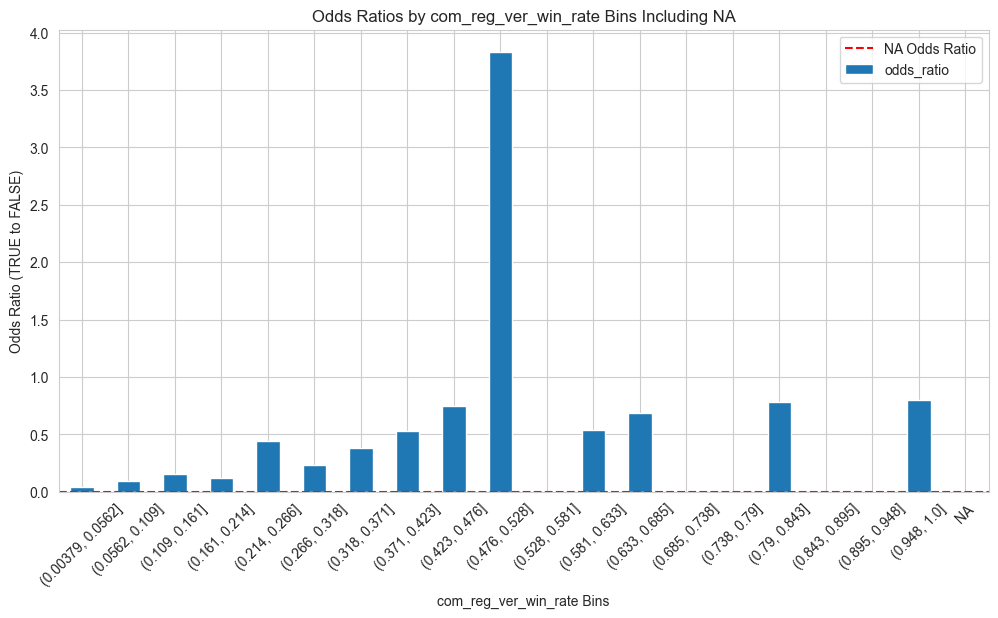

In [17]:
#결과

# Separate groups
na_group = df[df['com_reg_ver_win_rate'].isna()]
non_na_group = df[~df['com_reg_ver_win_rate'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'com_reg_ver_win_rate': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['com_reg_ver_win_rate'].min(), non_na_group['com_reg_ver_win_rate'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['com_reg_ver_win_rate'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('com_reg_ver_win_rate Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by com_reg_ver_win_rate Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### customer_type

In [18]:
df['customer_type'] = df['customer_type'].fillna('Unknown')

Odds Ratio for NA values in 'customer_type': 0.0


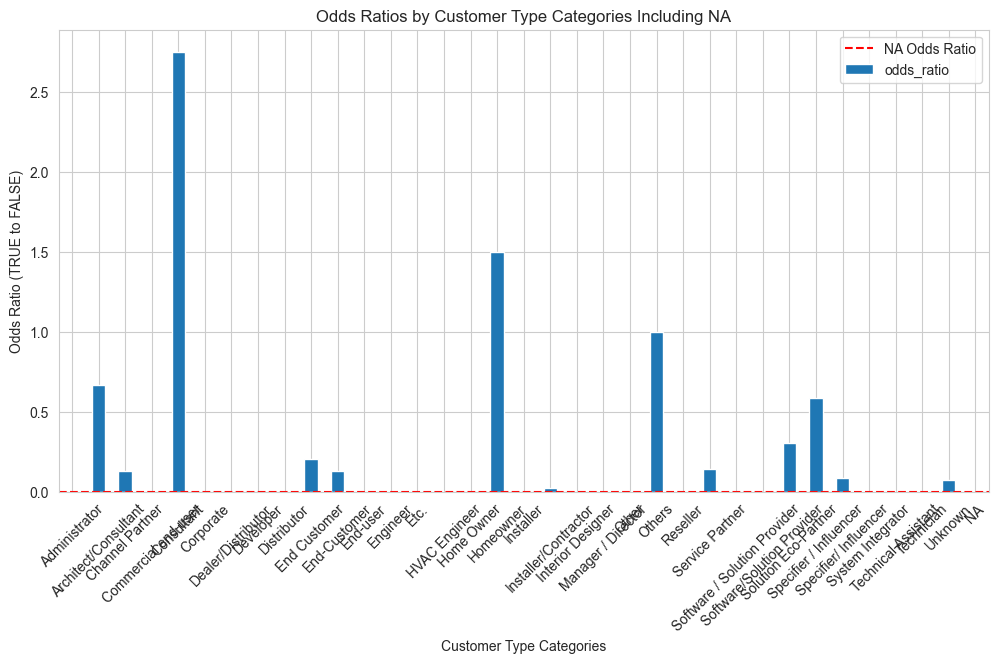

In [19]:
# Separate groups
na_group = df[df['customer_type'].isna()]
non_na_group = df[~df['customer_type'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'customer_type': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('customer_type')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('Customer Type Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by Customer Type Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### historical_existing_cnt

In [23]:
#erase the column

# df = df.drop(columns=['historical_existing_cnt'])

df.historical_existing_cnt.fillna(0, inplace=True)
df.historical_existing_cnt.unique()

array([0.000e+00, 1.200e+01, 1.440e+02, 3.000e+00, 2.300e+01, 4.700e+01,
       1.000e+00, 1.900e+01, 4.200e+01, 7.500e+01, 1.700e+01, 2.000e+01,
       5.000e+00, 2.000e+00, 1.150e+02, 4.000e+00, 1.600e+01, 6.000e+00,
       3.100e+01, 4.900e+01, 1.000e+01, 1.100e+01, 4.000e+01, 7.000e+00,
       6.100e+01, 4.500e+01, 5.700e+01, 1.750e+02, 1.300e+01, 9.900e+01,
       1.500e+01, 8.000e+00, 2.100e+01, 5.600e+01, 6.660e+02, 1.220e+02,
       3.240e+02, 2.200e+01, 8.000e+01, 3.600e+01, 2.800e+01, 1.720e+02,
       6.600e+01, 3.200e+01, 5.300e+01, 3.800e+01, 1.890e+02, 5.800e+01,
       2.700e+01, 1.060e+02, 1.680e+02, 9.000e+00, 4.600e+01, 4.800e+01,
       5.200e+01, 7.300e+01, 9.200e+01, 6.000e+01, 3.900e+01, 1.800e+01,
       1.400e+01, 2.120e+02, 4.720e+02, 3.900e+02, 6.900e+01, 2.330e+02,
       2.900e+01, 3.000e+01, 2.400e+01, 7.800e+01, 1.070e+02, 4.100e+01,
       1.660e+02, 5.900e+01, 4.400e+01, 1.140e+02, 3.700e+01, 3.500e+01,
       1.580e+02, 8.500e+01, 7.700e+01, 2.600e+01, 

In [22]:
len(df.columns)

29

## product subcategory

In [221]:
df['product_subcategory'] = df['product_subcategory'].fillna('NA')

Odds Ratio for NA values in 'product_subcategory': 0.0


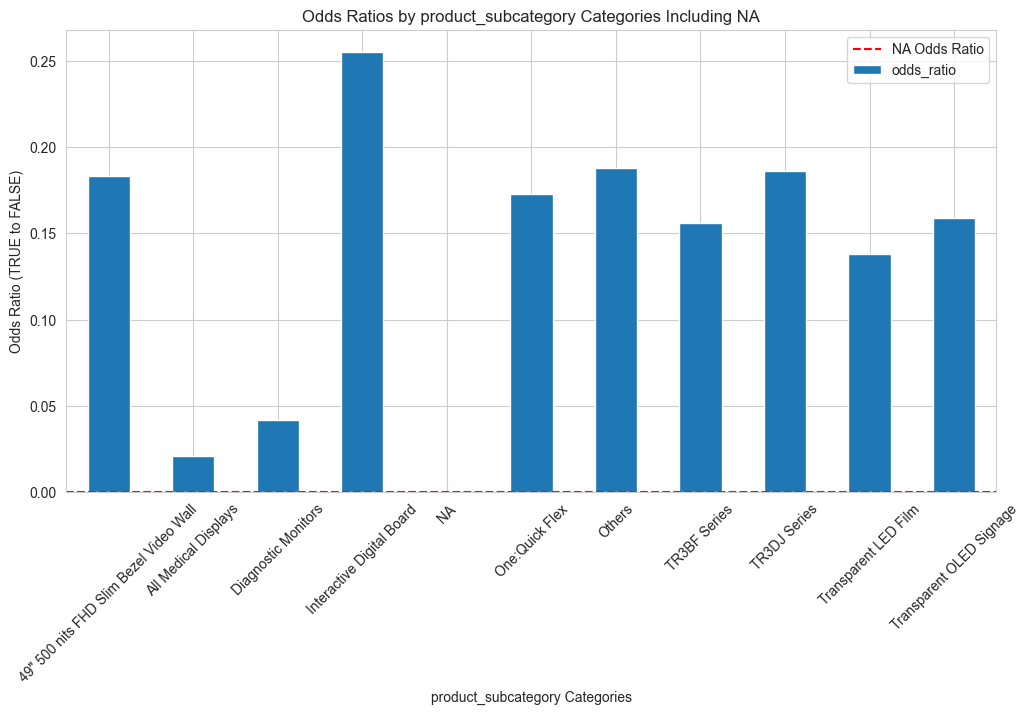

In [222]:
# 최고 10개만 거르는 코드
top_10_subcategories = df['product_subcategory'].value_counts().nlargest(10).index
df['product_subcategory'] = df['product_subcategory'].apply(lambda x: x if x in top_10_subcategories else 'Others')

# Separate groups
na_group = df[df['product_subcategory'].isna()]
non_na_group = df[~df['product_subcategory'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'product_subcategory': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('product_subcategory')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('product_subcategory Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by product_subcategory Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## product_modelname

In [223]:
df['product_modelname'] = df['product_modelname'].fillna('NA')

Odds Ratio for NA values in 'product_modelname': 0.0


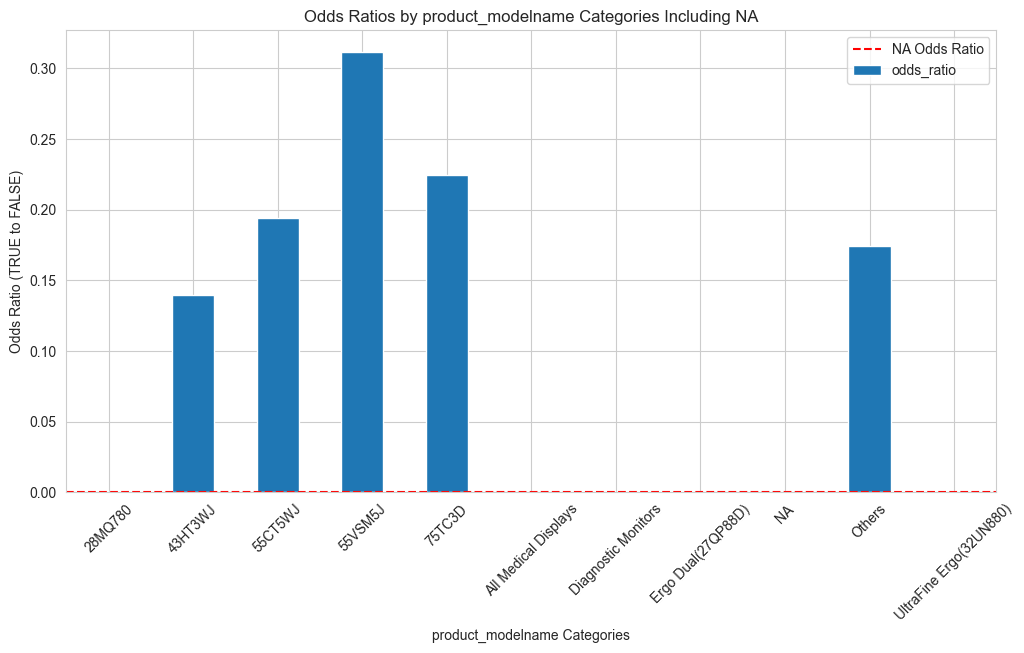

In [224]:
# 최고 10개만 거르는 코드
top_10_subcategories = df['product_modelname'].value_counts().nlargest(10).index
df['product_modelname'] = df['product_modelname'].apply(lambda x: x if x in top_10_subcategories else 'Others')

# Separate groups
na_group = df[df['product_modelname'].isna()]
non_na_group = df[~df['product_modelname'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'product_modelname': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('product_modelname')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('product_modelname Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by product_modelname Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## expected_timeline

In [225]:
# Replace the specified 'expected_timeline' values
df['expected_timeline'] = df['expected_timeline'].replace({
    'less_than_3_months': 'less than 3 months',  # merge into 'less than 3 months'
    'being followed up': 'being followed up.',  # merge into 'being followed up.'
    'less than 6 months': '3 months ~ 6 months',  # merge into '3 months ~ 6 months'
    '3_months_~_6_months' : '3 months ~ 6 months'
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['expected_timeline'].value_counts()
print(updated_counts)

expected_timeline
less than 3 months                                                                                                            16843
3 months ~ 6 months                                                                                                            4915
more than a year                                                                                                               2874
9 months ~ 1 year                                                                                                              1070
6 months ~ 9 months                                                                                                            1043
                                                                                                                              ...  
no requirement of this time                                                                                                       1
not reachable , lead shared with partner                  

In [226]:
top_expected_timelines = df['expected_timeline'].value_counts().nlargest(6).index

# Replace all other 'expected_timeline' values with 'Others'
df['expected_timeline'] = df['expected_timeline'].apply(lambda x: x if x in top_expected_timelines else 'Others')

In [227]:
df['expected_timeline'] = df['expected_timeline'].fillna('etc')

Odds Ratio for NA values in 'expected_timeline': 0.0


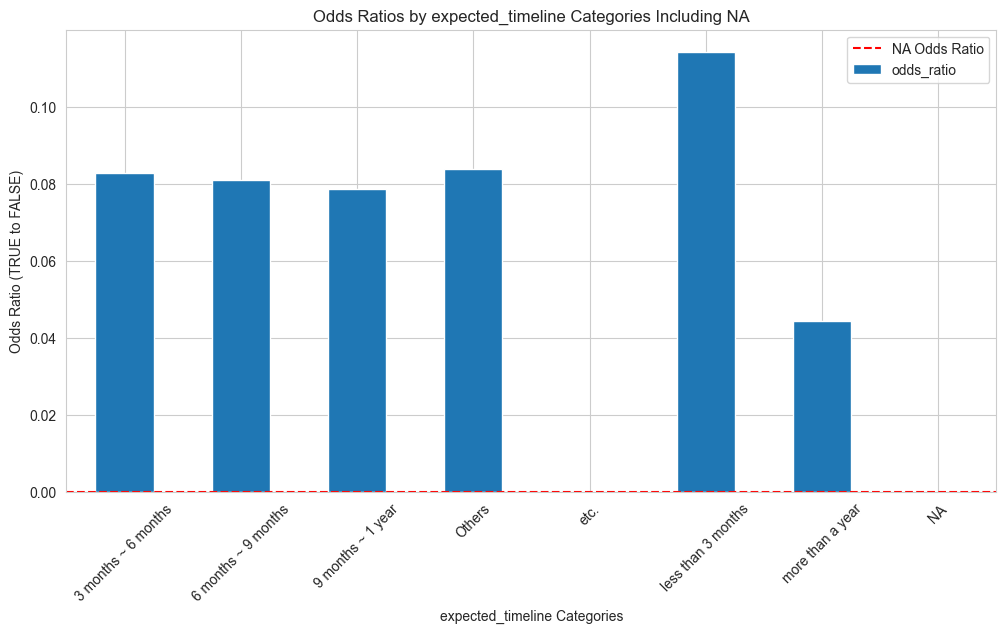

In [228]:
# Separate groups
na_group = df[df['expected_timeline'].isna()]
non_na_group = df[~df['expected_timeline'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'expected_timeline': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('expected_timeline')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('expected_timeline Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by expected_timeline Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## ver_win_rate_x

In [229]:
# 여기는 좀 고민이됨.
# df['ver_win_rate_x'] = df['ver_win_rate_x'].fillna()

Odds Ratio for NA values in 'ver_win_rate_x': 0.0968272756141921


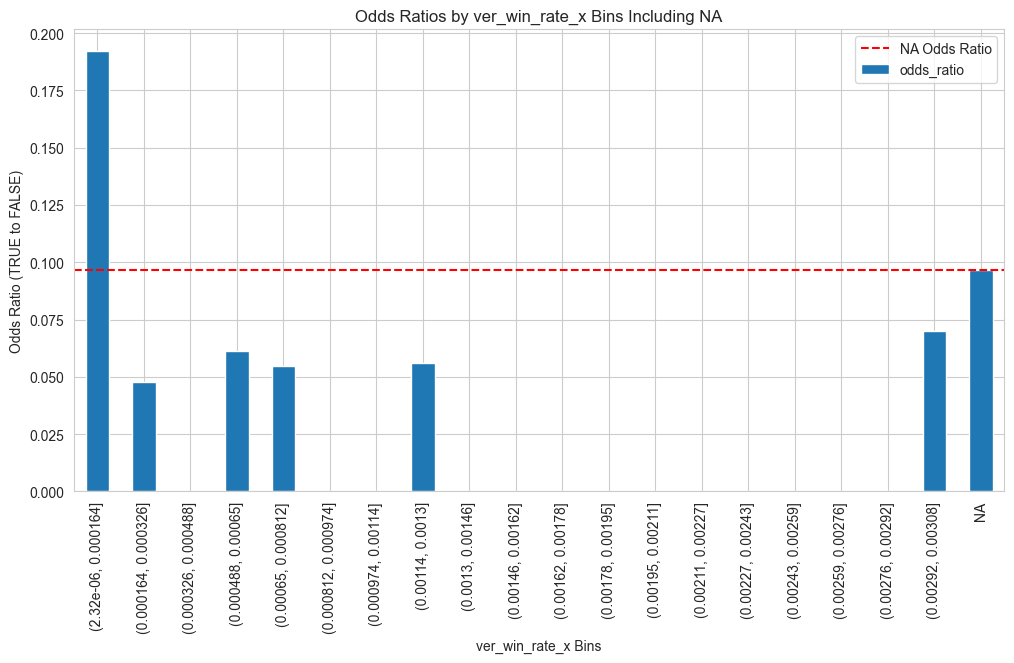

In [230]:
# Separate groups
na_group = df[df['ver_win_rate_x'].isna()]
non_na_group = df[~df['ver_win_rate_x'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'ver_win_rate_x': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['ver_win_rate_x'].min(), non_na_group['ver_win_rate_x'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['ver_win_rate_x'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_rate_x Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_rate_x Bins Including NA')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [231]:
# Identifying non-float values in all columns that should be numerical
# This will store the non-float entries for each numerical column
non_float_values = {}


# Make sure to check only those columns that should contain float value
# Find entries in the column that cannot be converted to float
non_float_entries = df['ver_win_rate_x'].apply(lambda x: isinstance(x, str) and not x.replace('.', '', 1).isdigit())
if non_float_entries.any():
    # Store the non-float entries in the dictionary
    non_float_values['ver_win_rate_x'] = df.loc[non_float_entries, 'ver_win_rate_x']

non_float_values.keys(), {key: non_float_values[key].unique() for key in non_float_values}


(dict_keys([]), {})

In [232]:
from sklearn.impute import KNNImputer

# Initialize the KNN Imputer with default parameters (you can choose to modify these)
imputer = KNNImputer(n_neighbors=5)

# It's important to note that KNNImputer works with numerical data, so we need to ensure that 'ver_win_rate_x' is of a numerical type
# Let's first ensure the column is of a numerical type, converting it if necessary
df['ver_win_rate_x'] = pd.to_numeric(df['ver_win_rate_x'], errors='coerce')

# Apply the imputer to the DataFrame
# df_imputed = df.copy()
# df_imputed['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
df['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
# Check the first few entries of the column to verify imputation
# df_imputed['ver_win_rate_x'].head()
df['ver_win_rate_x'].head()

0    0.003079
1    0.003079
2    0.003079
3    0.003079
4    0.003079
Name: ver_win_rate_x, dtype: float64

Odds Ratio for NA values in 'ver_win_rate_x': 0.0


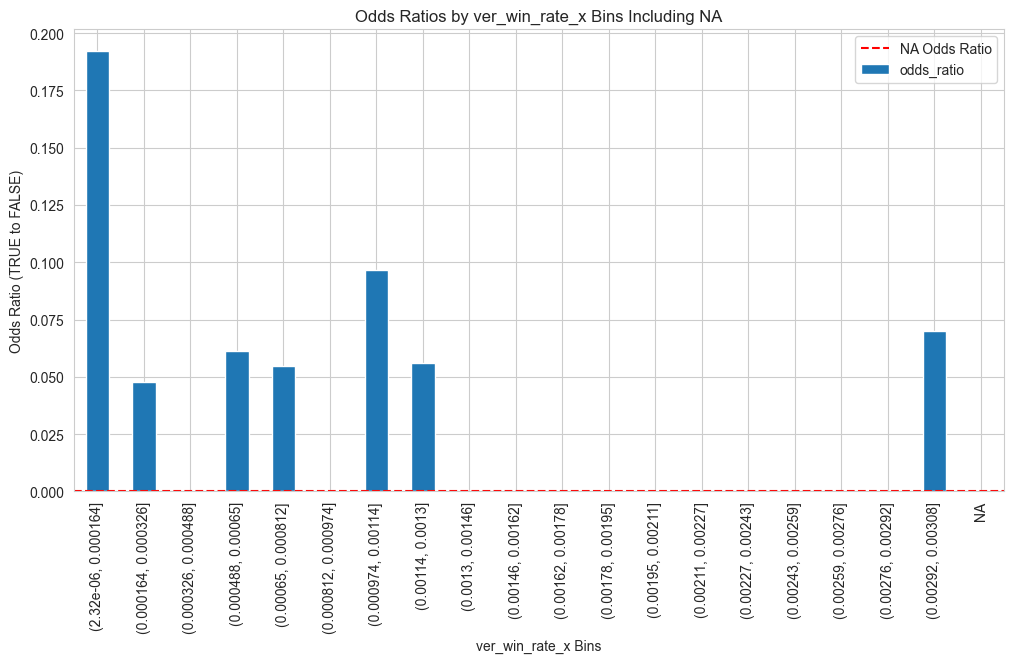

In [245]:
# Separate groups
na_group = df[df['ver_win_rate_x'].isna()]
non_na_group = df[~df['ver_win_rate_x'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'ver_win_rate_x': {odds_ratio_na}")

# Bin 'com_reg_ver_win_rate' for non-NA values
bins = np.linspace(non_na_group['ver_win_rate_x'].min(), non_na_group['ver_win_rate_x'].max(), 20)
non_na_group['binned'] = pd.cut(non_na_group['ver_win_rate_x'], bins=bins)

# Calculate odds ratio for each bin
binned_odds_ratios = non_na_group.groupby('binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios['odds_ratio'] = binned_odds_ratios['TRUE'] / binned_odds_ratios['FALSE']

# Find the bin with odds ratio closest to that of NA values
closest_bin = binned_odds_ratios.iloc[(binned_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the binned odds ratios for visualization
binned_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
binned_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_rate_x Bins')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_rate_x Bins Including NA')
plt.legend()
plt.xticks(rotation=90)
plt.show()

## ver_win_ratio_per_bu

Odds Ratio for NA values in 'ver_win_ratio_per_bu': 0.09947306161952899


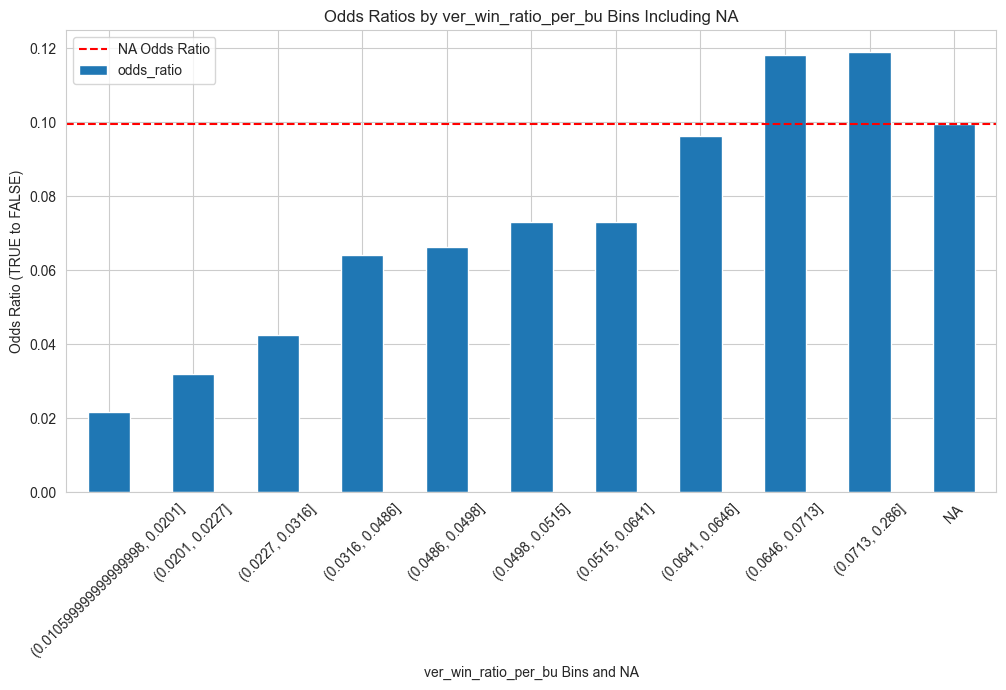

In [24]:
# Calculate odds ratio for NA group in 'ver_win_ratio_per_bu'
na_group_ver_bu = df[df['ver_win_ratio_per_bu'].isna()]
odds_ratio_na_ver_bu = na_group_ver_bu['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group_ver_bu['is_converted'].value_counts(normalize=True).get('FALSE', 1)

print(f"Odds Ratio for NA values in 'ver_win_ratio_per_bu': {odds_ratio_na_ver_bu}")

# Working with the non-NA subset for 'ver_win_ratio_per_bu'
non_na_group_ver_bu = df.dropna(subset=['ver_win_ratio_per_bu'])

# Bin 'ver_win_ratio_per_bu' into quantiles for fair distribution
non_na_group_ver_bu['ver_win_ratio_per_bu_binned'] = pd.qcut(non_na_group_ver_bu['ver_win_ratio_per_bu'], q=10, duplicates='drop')

# Calculate odds ratio for each bin
binned_odds_ratios_ver_bu = non_na_group_ver_bu.groupby('ver_win_ratio_per_bu_binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios_ver_bu['odds_ratio'] = binned_odds_ratios_ver_bu['TRUE'] / binned_odds_ratios_ver_bu['FALSE']

# Find bin with odds ratio closest to that of NA values
closest_bin_ver_bu = binned_odds_ratios_ver_bu.iloc[(binned_odds_ratios_ver_bu['odds_ratio'] - odds_ratio_na_ver_bu).abs().argsort()[:1]]

# Visualization
plt.figure(figsize=(12, 6))

# Convert index to string for consistent handling and visualization
binned_odds_ratios_ver_bu.index = binned_odds_ratios_ver_bu.index.astype(str)

# Now adding 'NA' as a string should not cause sorting issues
binned_odds_ratios_ver_bu.loc['NA', 'odds_ratio'] = odds_ratio_na_ver_bu

# Sort index alphabetically, which now includes 'NA' as a comparable string type
binned_odds_ratios_ver_bu = binned_odds_ratios_ver_bu.sort_index()

binned_odds_ratios_ver_bu['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na_ver_bu, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_ratio_per_bu Bins and NA')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_ratio_per_bu Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [25]:
# df['ver_win_ratio_per_bu'] = df['ver_win_ratio_per_bu'].fillna(0.0645)

from sklearn.impute import KNNImputer

# Initialize the KNN Imputer with default parameters (you can choose to modify these)
imputer = KNNImputer(n_neighbors=5)

# It's important to note that KNNImputer works with numerical data, so we need to ensure that 'ver_win_rate_x' is of a numerical type
# Let's first ensure the column is of a numerical type, converting it if necessary
df['ver_win_ratio_per_bu'] = pd.to_numeric(df['ver_win_ratio_per_bu'], errors='coerce')

# Apply the imputer to the DataFrame
# df_imputed = df.copy()
# df_imputed['ver_win_rate_x'] = imputer.fit_transform(df[['ver_win_rate_x']])
df['ver_win_ratio_per_bu'] = imputer.fit_transform(df[['ver_win_ratio_per_bu']])
# Check the first few entries of the column to verify imputation
# df_imputed['ver_win_rate_x'].head()
df['ver_win_ratio_per_bu'].head()

0    0.026846
1    0.026846
2    0.026846
3    0.026846
4    0.026846
Name: ver_win_ratio_per_bu, dtype: float64

Odds Ratio for NA values in 'ver_win_ratio_per_bu': 0.0


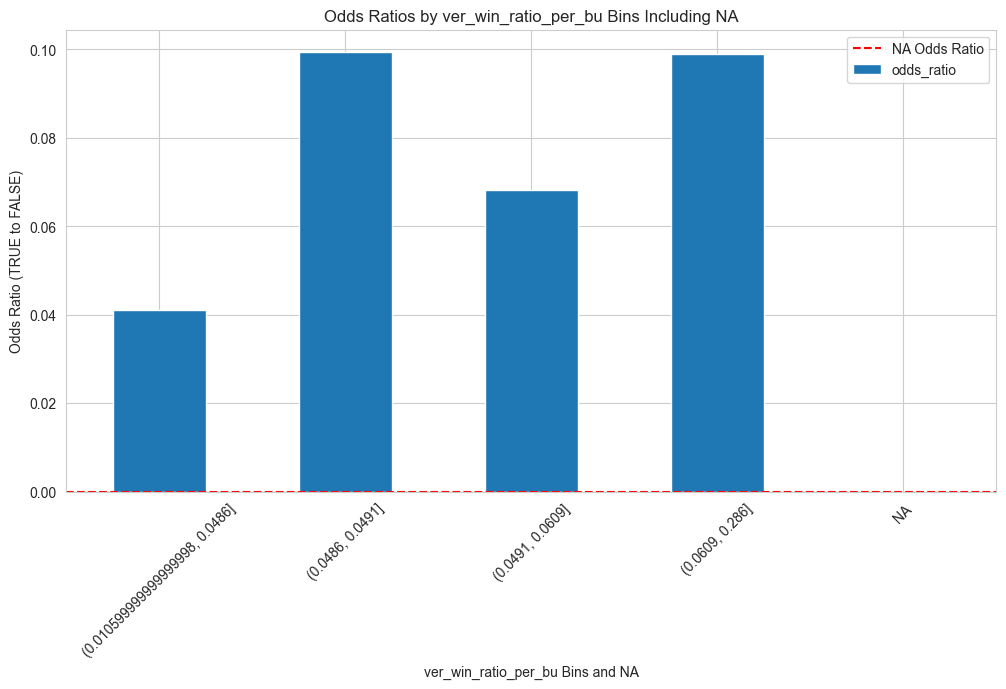

In [26]:
# Calculate odds ratio for NA group in 'ver_win_ratio_per_bu'
na_group_ver_bu = df[df['ver_win_ratio_per_bu'].isna()]
odds_ratio_na_ver_bu = na_group_ver_bu['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group_ver_bu['is_converted'].value_counts(normalize=True).get('FALSE', 1)

print(f"Odds Ratio for NA values in 'ver_win_ratio_per_bu': {odds_ratio_na_ver_bu}")

# Working with the non-NA subset for 'ver_win_ratio_per_bu'
non_na_group_ver_bu = df.dropna(subset=['ver_win_ratio_per_bu'])

# Bin 'ver_win_ratio_per_bu' into quantiles for fair distribution
non_na_group_ver_bu['ver_win_ratio_per_bu_binned'] = pd.qcut(non_na_group_ver_bu['ver_win_ratio_per_bu'], q=10, duplicates='drop')

# Calculate odds ratio for each bin
binned_odds_ratios_ver_bu = non_na_group_ver_bu.groupby('ver_win_ratio_per_bu_binned')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
binned_odds_ratios_ver_bu['odds_ratio'] = binned_odds_ratios_ver_bu['TRUE'] / binned_odds_ratios_ver_bu['FALSE']

# Find bin with odds ratio closest to that of NA values
closest_bin_ver_bu = binned_odds_ratios_ver_bu.iloc[(binned_odds_ratios_ver_bu['odds_ratio'] - odds_ratio_na_ver_bu).abs().argsort()[:1]]

# Visualization
plt.figure(figsize=(12, 6))

# Convert index to string for consistent handling and visualization
binned_odds_ratios_ver_bu.index = binned_odds_ratios_ver_bu.index.astype(str)

# Now adding 'NA' as a string should not cause sorting issues
binned_odds_ratios_ver_bu.loc['NA', 'odds_ratio'] = odds_ratio_na_ver_bu

# Sort index alphabetically, which now includes 'NA' as a comparable string type
binned_odds_ratios_ver_bu = binned_odds_ratios_ver_bu.sort_index()

binned_odds_ratios_ver_bu['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na_ver_bu, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('ver_win_ratio_per_bu Bins and NA')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by ver_win_ratio_per_bu Bins Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## business_area

In [249]:
df['business_area'] = df['business_area'].fillna('NA')

Odds Ratio for NA values in 'business_area': 0.0


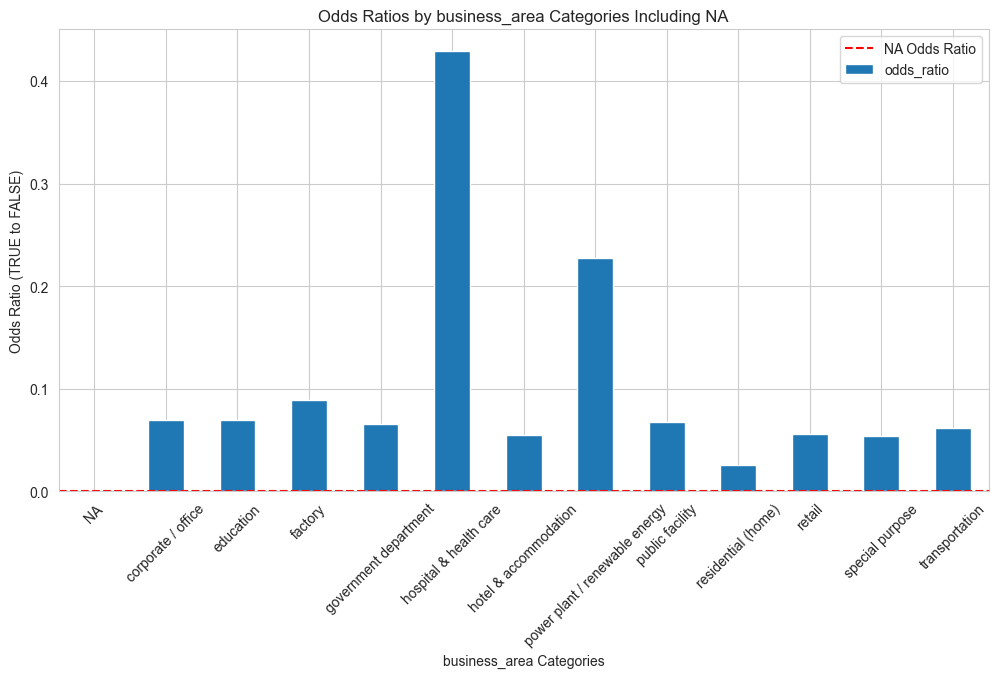

In [250]:
# Separate groups
na_group = df[df['business_area'].isna()]
non_na_group = df[~df['business_area'].isna()]

# Calculate odds ratio for NA group
odds_ratio_na = na_group['is_converted'].value_counts(normalize=True).get('TRUE', 0) / \
                na_group['is_converted'].value_counts(normalize=True).get('FALSE', 1)

# Display the odds ratio for NA values
print(f"Odds Ratio for NA values in 'business_area': {odds_ratio_na}")

# Calculate odds ratio for each category in 'customer_type'
category_odds_ratios = non_na_group.groupby('business_area')['is_converted'].value_counts(normalize=True).unstack().fillna(0)
category_odds_ratios['odds_ratio'] = category_odds_ratios['TRUE'] / category_odds_ratios['FALSE']

# Find the category with odds ratio closest to that of NA values
closest_category = category_odds_ratios.iloc[(category_odds_ratios['odds_ratio'] - odds_ratio_na).abs().argsort()[:1]]

# Add NA odds ratio to the category odds ratios for visualization
category_odds_ratios.loc['NA', 'odds_ratio'] = odds_ratio_na

plt.figure(figsize=(12, 6))
category_odds_ratios['odds_ratio'].plot(kind='bar')
plt.axhline(y=odds_ratio_na, color='r', linestyle='--', label='NA Odds Ratio')
plt.xlabel('business_area Categories')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratios by business_area Categories Including NA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# NA율 50% 이하

## customer_job

In [251]:
df['customer_job'] = df['customer_job'].fillna('NA')

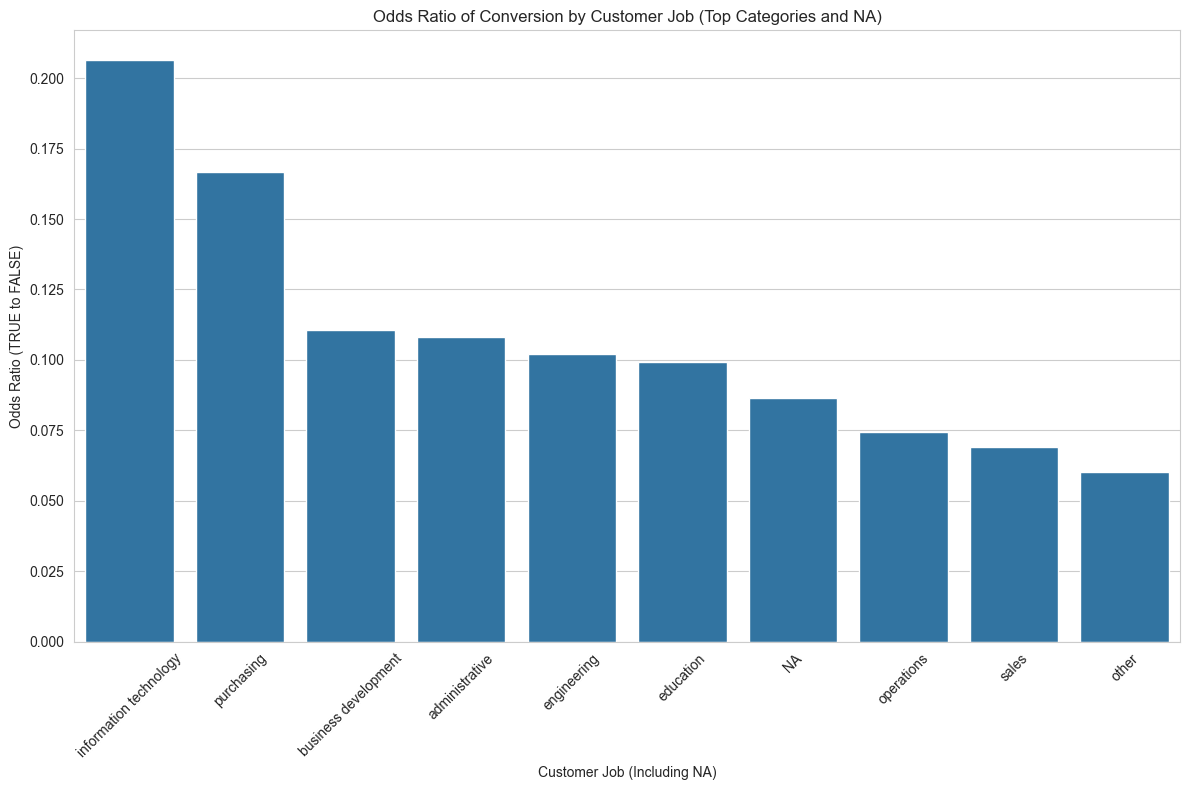

In [252]:
# Find the top 'customer_job' categories by count, excluding NAs
top_categories_counts = df['customer_job'].value_counts().nlargest(10)

# Include NA by creating a new category for visualization
df['customer_job_category'] = df['customer_job'].fillna('NA')

# Ensure the new "NA" category is included only if you want to compare it directly
df.loc[df['customer_job'].isna(), 'customer_job_category'] = 'NA'
top_categories_with_na = top_categories_counts.index.tolist() + ['NA']

df_filtered = df[df['customer_job_category'].isin(top_categories_with_na)]

# Calculate counts and odds ratios
conversion_counts = df_filtered.groupby('customer_job_category')['is_converted'].value_counts().unstack(fill_value=0)
conversion_counts['odds_ratio'] = conversion_counts['TRUE'] / conversion_counts.get('FALSE', 1)  # Avoid division by zero

# Reset index for plotting
conversion_counts.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=conversion_counts, x='customer_job_category', y='odds_ratio', order=conversion_counts.sort_values('odds_ratio', ascending=False)['customer_job_category'])
plt.xticks(rotation=45)
plt.xlabel('Customer Job (Including NA)')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Customer Job (Top Categories and NA)')
plt.tight_layout()
plt.show()


## product_category

In [253]:
df['product_category'] = df['product_category'].fillna('NA')

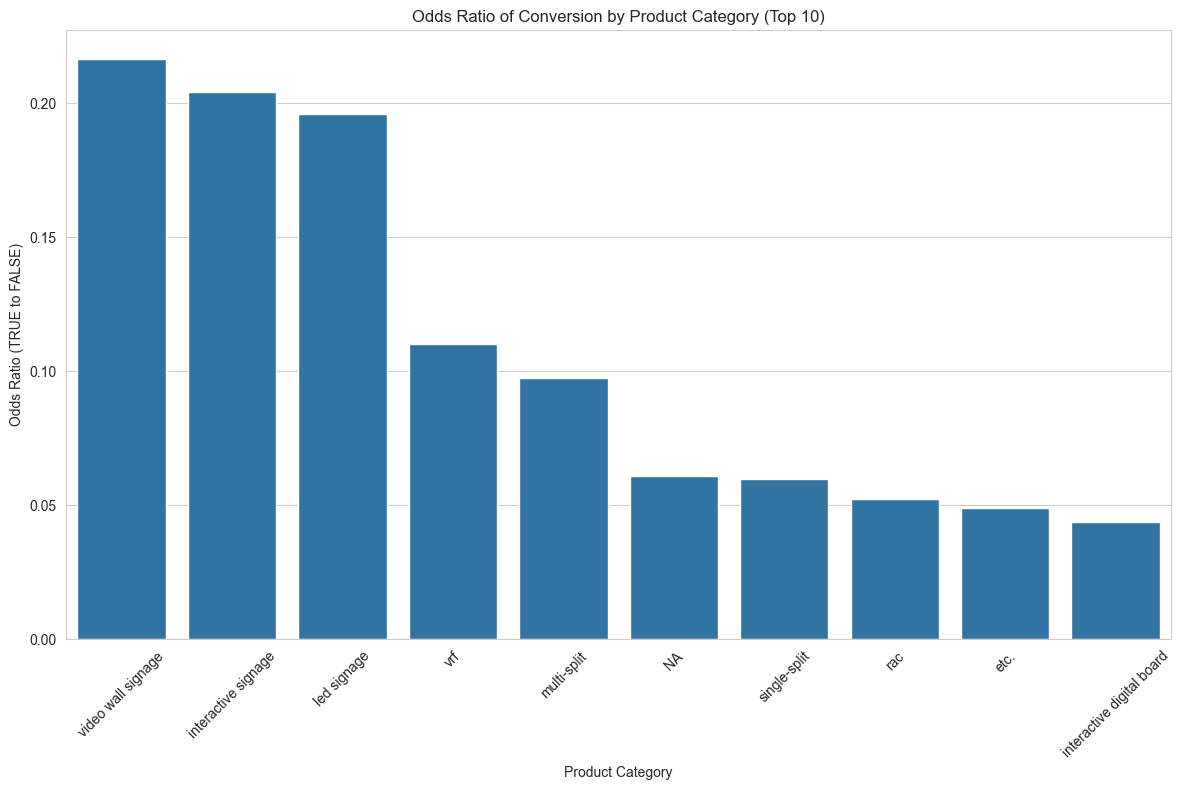

In [254]:
# Find the top 10 'product_category' categories by count
top_10_product_categories = df['product_category'].value_counts().nlargest(10).index

# Filter the DataFrame to keep only rows with the top 10 'product_category' values
df_top_10_product_categories = df[df['product_category'].isin(top_10_product_categories)]

# Calculate counts and odds ratios
conversion_counts_top_10 = df_top_10_product_categories.groupby('product_category')['is_converted'].value_counts().unstack(fill_value=0)
conversion_counts_top_10['odds_ratio'] = conversion_counts_top_10['TRUE'] / conversion_counts_top_10.get('FALSE', 1)  # Avoid division by zero

# Reset index for plotting
conversion_counts_top_10.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=conversion_counts_top_10, x='product_category', y='odds_ratio', order=conversion_counts_top_10.sort_values('odds_ratio', ascending=False)['product_category'])
plt.xticks(rotation=45)
plt.xlabel('Product Category')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Product Category (Top 10)')
plt.tight_layout()
plt.show()

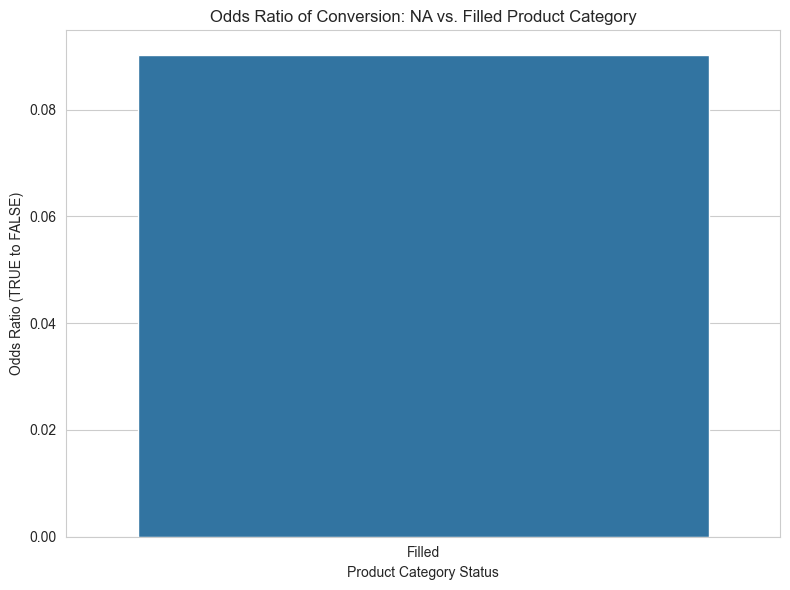

In [255]:
# Create a new column to differentiate between NA and non-NA 'product_category' values
df['product_category_status'] = np.where(df['product_category'].isna(), 'NA', 'Filled')

# Calculate counts and odds ratios for NA vs. Non-NA
conversion_counts_status = df.groupby('product_category_status')['is_converted'].value_counts().unstack(fill_value=0)
conversion_counts_status['odds_ratio'] = conversion_counts_status['TRUE'] / conversion_counts_status.get('FALSE', 1)

# Reset index for plotting
conversion_counts_status.reset_index(inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(data=conversion_counts_status, x='product_category_status', y='odds_ratio')
plt.xlabel('Product Category Status')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion: NA vs. Filled Product Category')
plt.tight_layout()
plt.show()

#no more NA


## NA 1000개 행 이하

In [244]:
for col in df.columns:
    if df[col].isnull().sum() > 1:
        print(col, df[col].isnull().sum()/len(df)*100)
        print(col, df[col].isnull().sum())

customer_country 1.7461455718895662
customer_country 974
inquiry_type 1.597346719254213
inquiry_type 891
customer_country.1 1.7461455718895662
customer_country.1 974


In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55780 entries, 0 to 59298
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              55780 non-null  float64
 1   customer_country         54806 non-null  object 
 2   business_unit            55780 non-null  object 
 3   com_reg_ver_win_rate     55780 non-null  float64
 4   customer_idx             55780 non-null  int64  
 5   customer_type            55780 non-null  object 
 6   enterprise               55780 non-null  object 
 7   customer_job             55780 non-null  object 
 8   lead_desc_length         55780 non-null  int64  
 9   inquiry_type             54889 non-null  object 
 10  product_category         55780 non-null  object 
 11  product_subcategory      55780 non-null  object 
 12  product_modelname        55780 non-null  object 
 13  customer_country.1       54806 non-null  object 
 14  customer_position        55

In [261]:
df_dropped = df.dropna(subset=['customer_country','inquiry_type'])
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54481 entries, 0 to 59298
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              54481 non-null  float64
 1   customer_country         54481 non-null  object 
 2   business_unit            54481 non-null  object 
 3   com_reg_ver_win_rate     54481 non-null  float64
 4   customer_idx             54481 non-null  int64  
 5   customer_type            54481 non-null  object 
 6   enterprise               54481 non-null  object 
 7   customer_job             54481 non-null  object 
 8   lead_desc_length         54481 non-null  int64  
 9   inquiry_type             54481 non-null  object 
 10  product_category         54481 non-null  object 
 11  product_subcategory      54481 non-null  object 
 12  product_modelname        54481 non-null  object 
 13  customer_country.1       54481 non-null  object 
 14  customer_position        54

## print pre-processed 

In [262]:
df.to_csv('preprocessed_train.csv', index=False)